# 2020-05-07: Data analysis of B4R/PJ020941.3

In [1]:
import tools
from scipy.ndimage import median_filter, uniform_filter
from sklearn.decomposition import TruncatedSVD

median_filter = dataarray_func(median_filter)
uniform_filter = dataarray_func(uniform_filter)

def find_path(dir_path, file_pattern):
    return list(dir_path.glob(file_pattern))[0]

def cov(X):
    X_norm = (X - X.mean("t")) / X.std("t")
    cov = np.cov(X_norm.T)
    cov[np.diag_indices_from(cov)] = np.nan
    return cov

## GoDec algorithm for fPSW observations

In [2]:
def estimate_S(X, L, k=25, w=5):
    """Estimate sparse matrix (S)."""
    S = X - L
    phi = S.scantype == "ON"
    spec = S.where(phi).sum("t")
    
    # smooth spectrum (optional)
    if w > 0:
        spec = median_filter(spec, w)

    # k-th largest absolute values -> True
    spec = np.abs(spec)
    theta = (-spec).argsort().argsort() < k
    
    return S * (phi * theta)


def estimate_L(X, S, r=5, seed=2021):
    """Estimate low-rank matrix (L)."""
    R = X - S
    R0 = R.mean("t")

    model = TruncatedSVD(r, random_state=seed)
    C = model.fit_transform(R - R0)
    P = model.components_
    L = xr.full_like(X, C @ P) + R0

    return L

## Load data

In [3]:
target = "PJ020941.3"
obsnum_cal = "086895"
obsnum_sci = "086896"
ifnum = "02"
sideband = "USB"
T_amb = 273.0
ch_bin = 256

nc_cal = find_path(LDATA / target / "xffts", f"*{obsnum_cal}_{ifnum}.nc")
nc_sci = find_path(LDATA / target / "xffts", f"*{obsnum_sci}_{ifnum}.nc")
nc_tel_cal = find_path(LDATA / target / "lmttpm", f"*{obsnum_cal}*.nc")
nc_tel_sci = find_path(LDATA / target / "lmttpm", f"*{obsnum_sci}*.nc")

P_cal = tools.b4r.load_data_xffts(nc_cal, nc_tel_cal, sideband)
P_sci = tools.b4r.load_data_xffts(nc_sci, nc_tel_sci, sideband)

phi = P_sci.scantype == "ON"

## Reduce data by chopper-wheel calibration and linear baseline

In [4]:
T_cal_org = tools.b4r.calibrate_intensity(P_sci, P_cal, T_amb)
T_cal_org = tools.b4r.bin_channels(T_cal_org, ch_bin)

weight = (T_cal_org.ch < 161.9) | (T_cal_org.ch > 162.4)
T_base = tools.b4r.estimate_baseline(T_cal_org.fillna(0), weight=weight)
T_cal = (T_cal_org - T_base).where(phi, drop=True)

100%|██████████| 30/30 [00:00<00:00, 60.35it/s]


## Reduce data by the GoDec algorithm for fPSW observations

In [5]:
dP = P_sci - P_cal.where(P_cal.scanid == 0).mean("t")
dP = tools.b4r.bin_channels(dP, ch_bin)
X = np.log(-dP/T_amb)

/Users/akio/Repos/Reform/reform-analysis/.venv/lib/python3.8/site-packages/xarray/core/computation.py:604: RuntimeWarning: overflow encountered in log
  result_data = func(*input_data)


### With smoothing spectrum

In [6]:
r = 7
k = 25
w = 7

S = xr.zeros_like(X)

for i in tqdm(range(100)):
    L = estimate_L(X, S, r=r)
    S = estimate_S(X, L, k=k, w=w)

T_cal_re = T_amb * (1-np.exp(X-L))
T_cal_re = T_cal_re.where(phi, drop=True)

print(f"Nonzero: {(S!=0).sum().values/S.size:.1%}")

100%|██████████| 100/100 [00:00<00:00, 104.56it/s]

Nonzero: 9.6%


### Without smoothing spectrum

In [7]:
S = xr.zeros_like(X)

for i in tqdm(range(100)):
    L = estimate_L(X, S, r=r)
    S = estimate_S(X, L, k=k, w=0)

T_cal_re_w0 = T_amb * (1-np.exp(X-L))
T_cal_re_w0 = T_cal_re_w0.where(phi, drop=True)

print(f"Nonzero: {(S!=0).sum().values/S.size:.1%}")

100%|██████████| 100/100 [00:00<00:00, 111.28it/s]

Nonzero: 9.6%


## Make spectra and plot

In [8]:
weight = T_cal.std("ch") ** -2
spec = (weight * T_cal).sum("t") / weight.sum("t")

weight_re = T_cal_re.std("ch") ** -2
spec_re = (weight_re * T_cal_re).sum("t") / weight_re.sum("t")

weight_re_w0 = T_cal_re_w0.std("ch") ** -2
spec_re_w0 = (weight_re_w0 * T_cal_re_w0).sum("t") / weight_re_w0.sum("t")

In [9]:
T_base = xr.concat([T_cal.loc[:, :162.9], T_cal.loc[:, 161.9:]], "ch")
T_base_re = xr.concat([T_cal_re.loc[:, :162.9], T_cal_re.loc[:, 161.9:]], "ch")

cumstd = (T_base.cumsum("t") / xr.ones_like(T_base).cumsum("t")).std("ch")
cumstd_re = (T_base_re.cumsum("t") / xr.ones_like(T_base_re).cumsum("t")).std("ch")
cumint = T_base.integtime.cumsum("t")

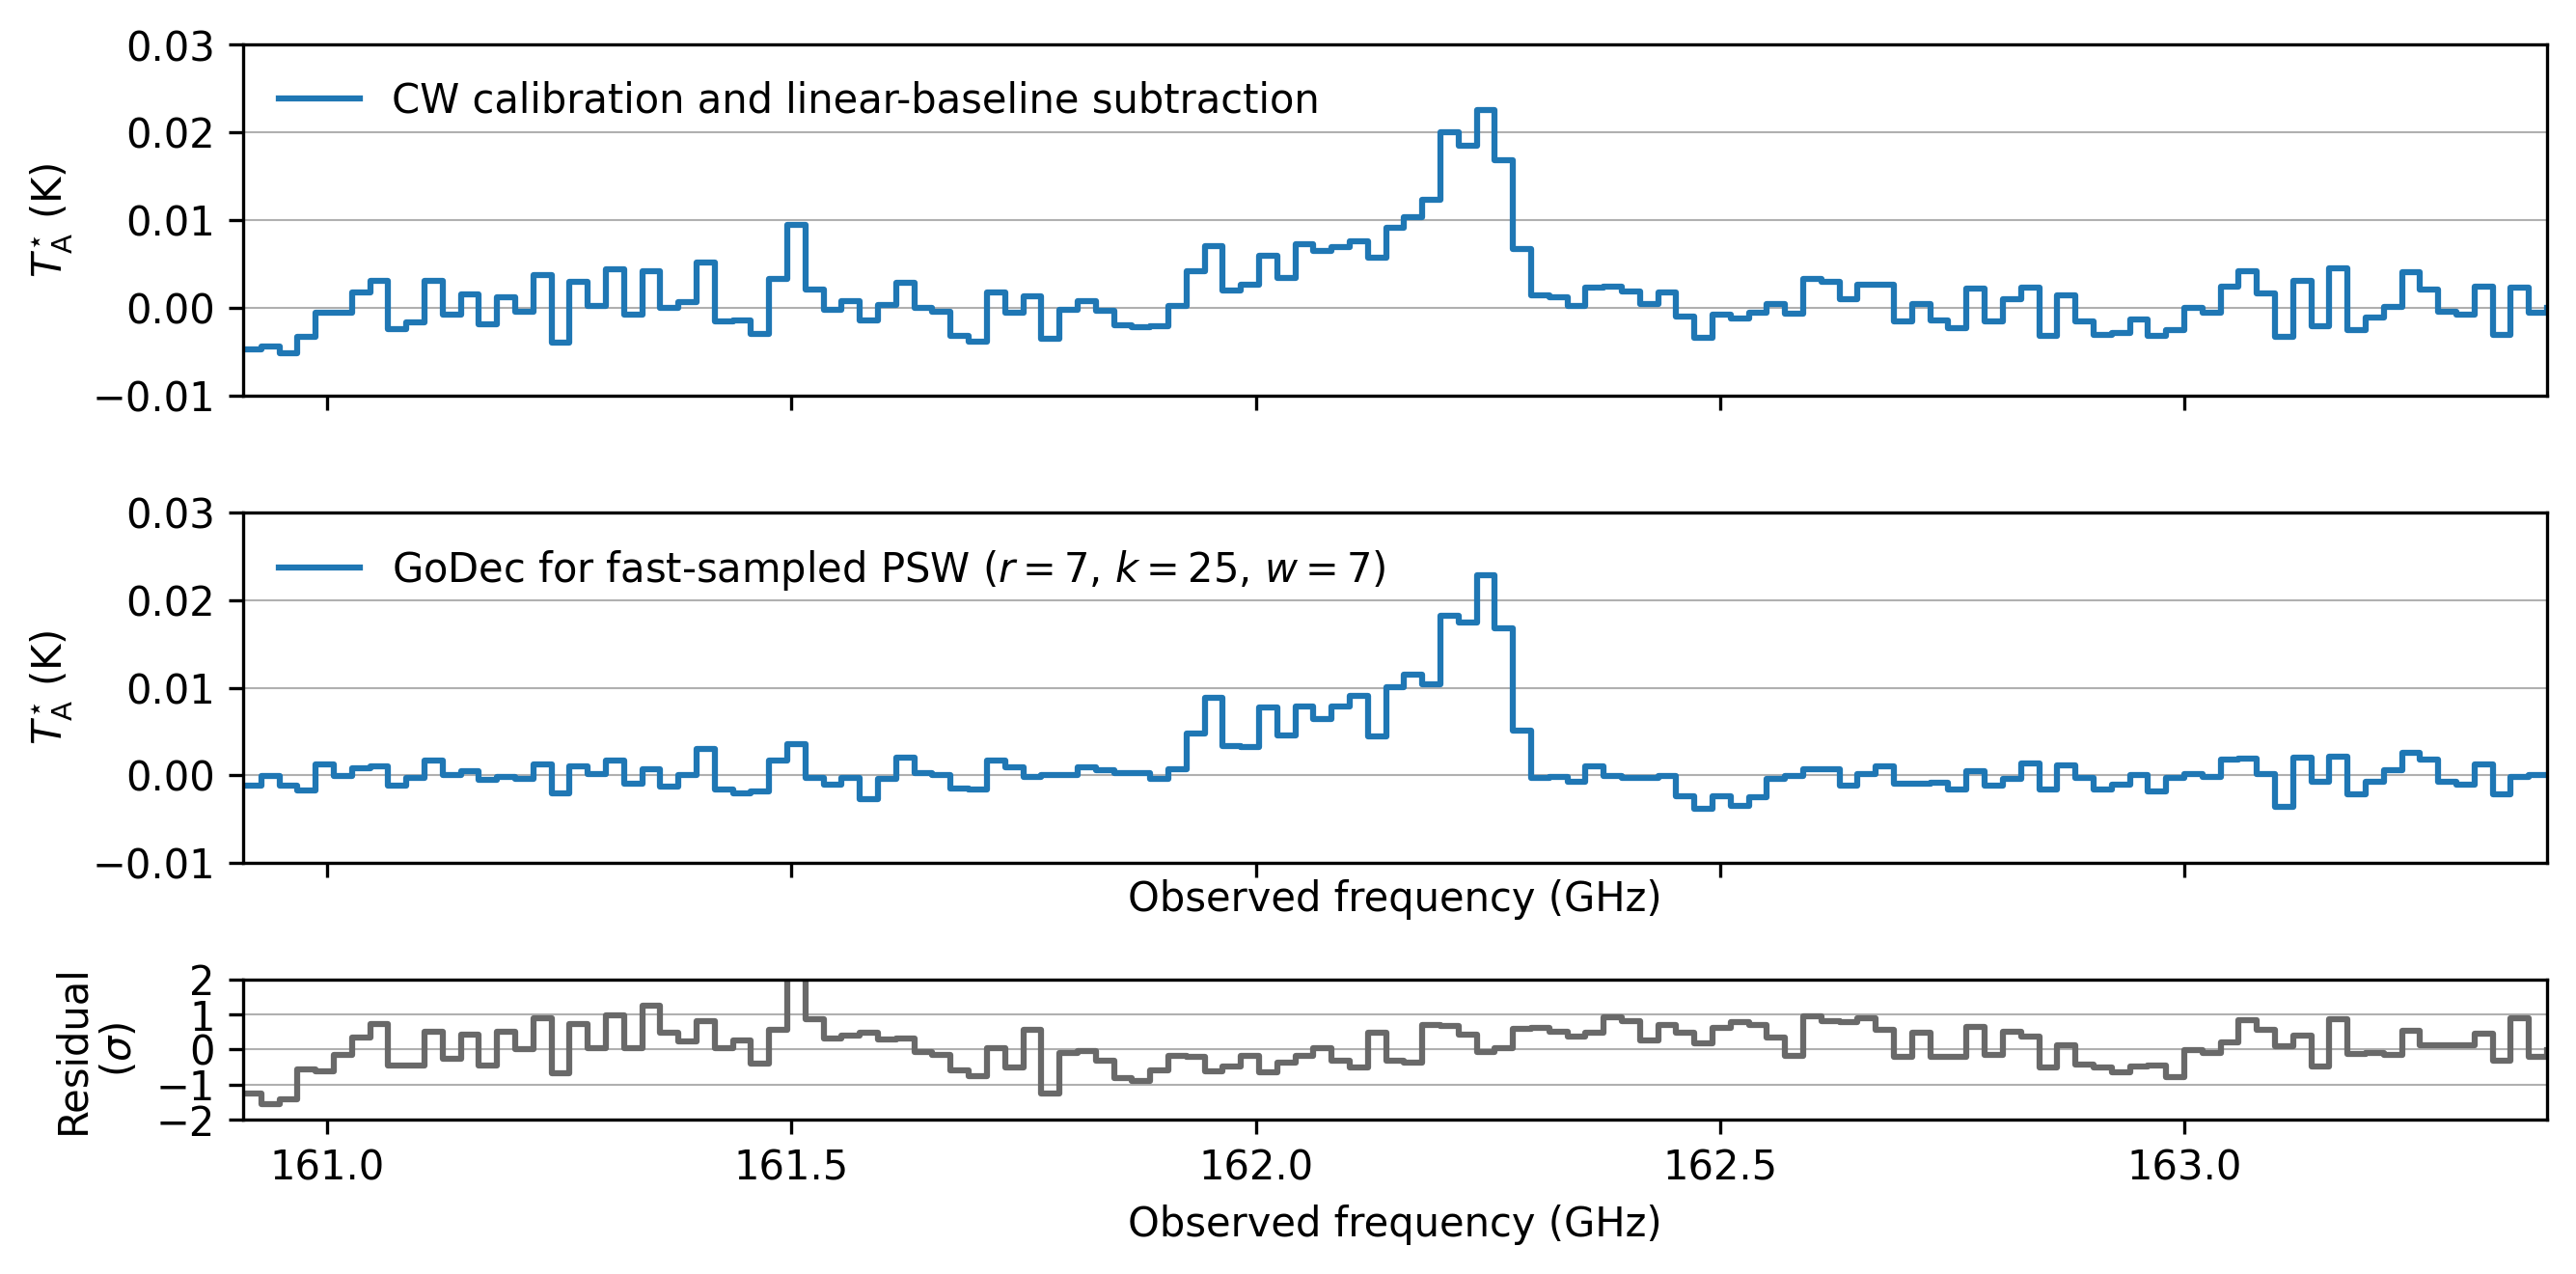

In [10]:
fig, axes = plt.subplots(3, 1, gridspec_kw={'height_ratios': [2.5, 2.5, 1]}, sharex=True, figsize=(9, 4.5), dpi=300)

ax = axes[0]
ax.step(spec.ch, spec, label="CW calibration and linear-baseline subtraction")
ax.set_ylabel(r"$T_{\mathrm{A}}^{\star}$ (K)")
ax.set_xlim(spec.ch.min(), spec.ch.max())
ax.set_ylim(-0.01, 0.03)
ax.legend(frameon=False)
ax.grid(axis="y", linewidth=0.5)

ax = axes[1]
ax.step(spec.ch, spec_re, label=f"GoDec for fast-sampled PSW ($r={r}$, $k={k}$, $w={w}$)")
ax.set_xlabel("Observed frequency (GHz)")
ax.set_ylabel(r"$T_{\mathrm{A}}^{\star}$ (K)")
ax.set_ylim(-0.01, 0.03)
ax.legend(frameon=False)
ax.grid(axis="y", linewidth=0.5)

ax = axes[2]
ax.step(spec.ch, (spec-spec_re)/cumstd[-1], color="dimgray")
ax.set_xlabel("Observed frequency (GHz)")
ax.set_ylabel("Residual\n($\sigma$)")
ax.set_ylim(-2, 2)
ax.set_yticks([-2, -1, 0, 1, 2])
ax.grid(axis="y", linewidth=0.5)

fig.tight_layout()
savefig_in_notebook(fig, "spectra-PJ020941_3-CO54.pdf")

<ipython-input-11-73590de1046e>:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap.set_bad("black")
<ipython-input-11-73590de1046e>:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
  cmap_pm.set_bad("black")
/Users/akio/Repos/Reform/reform-analysis/.venv/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/akio/Repos/Reform/reform-analysis/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarni

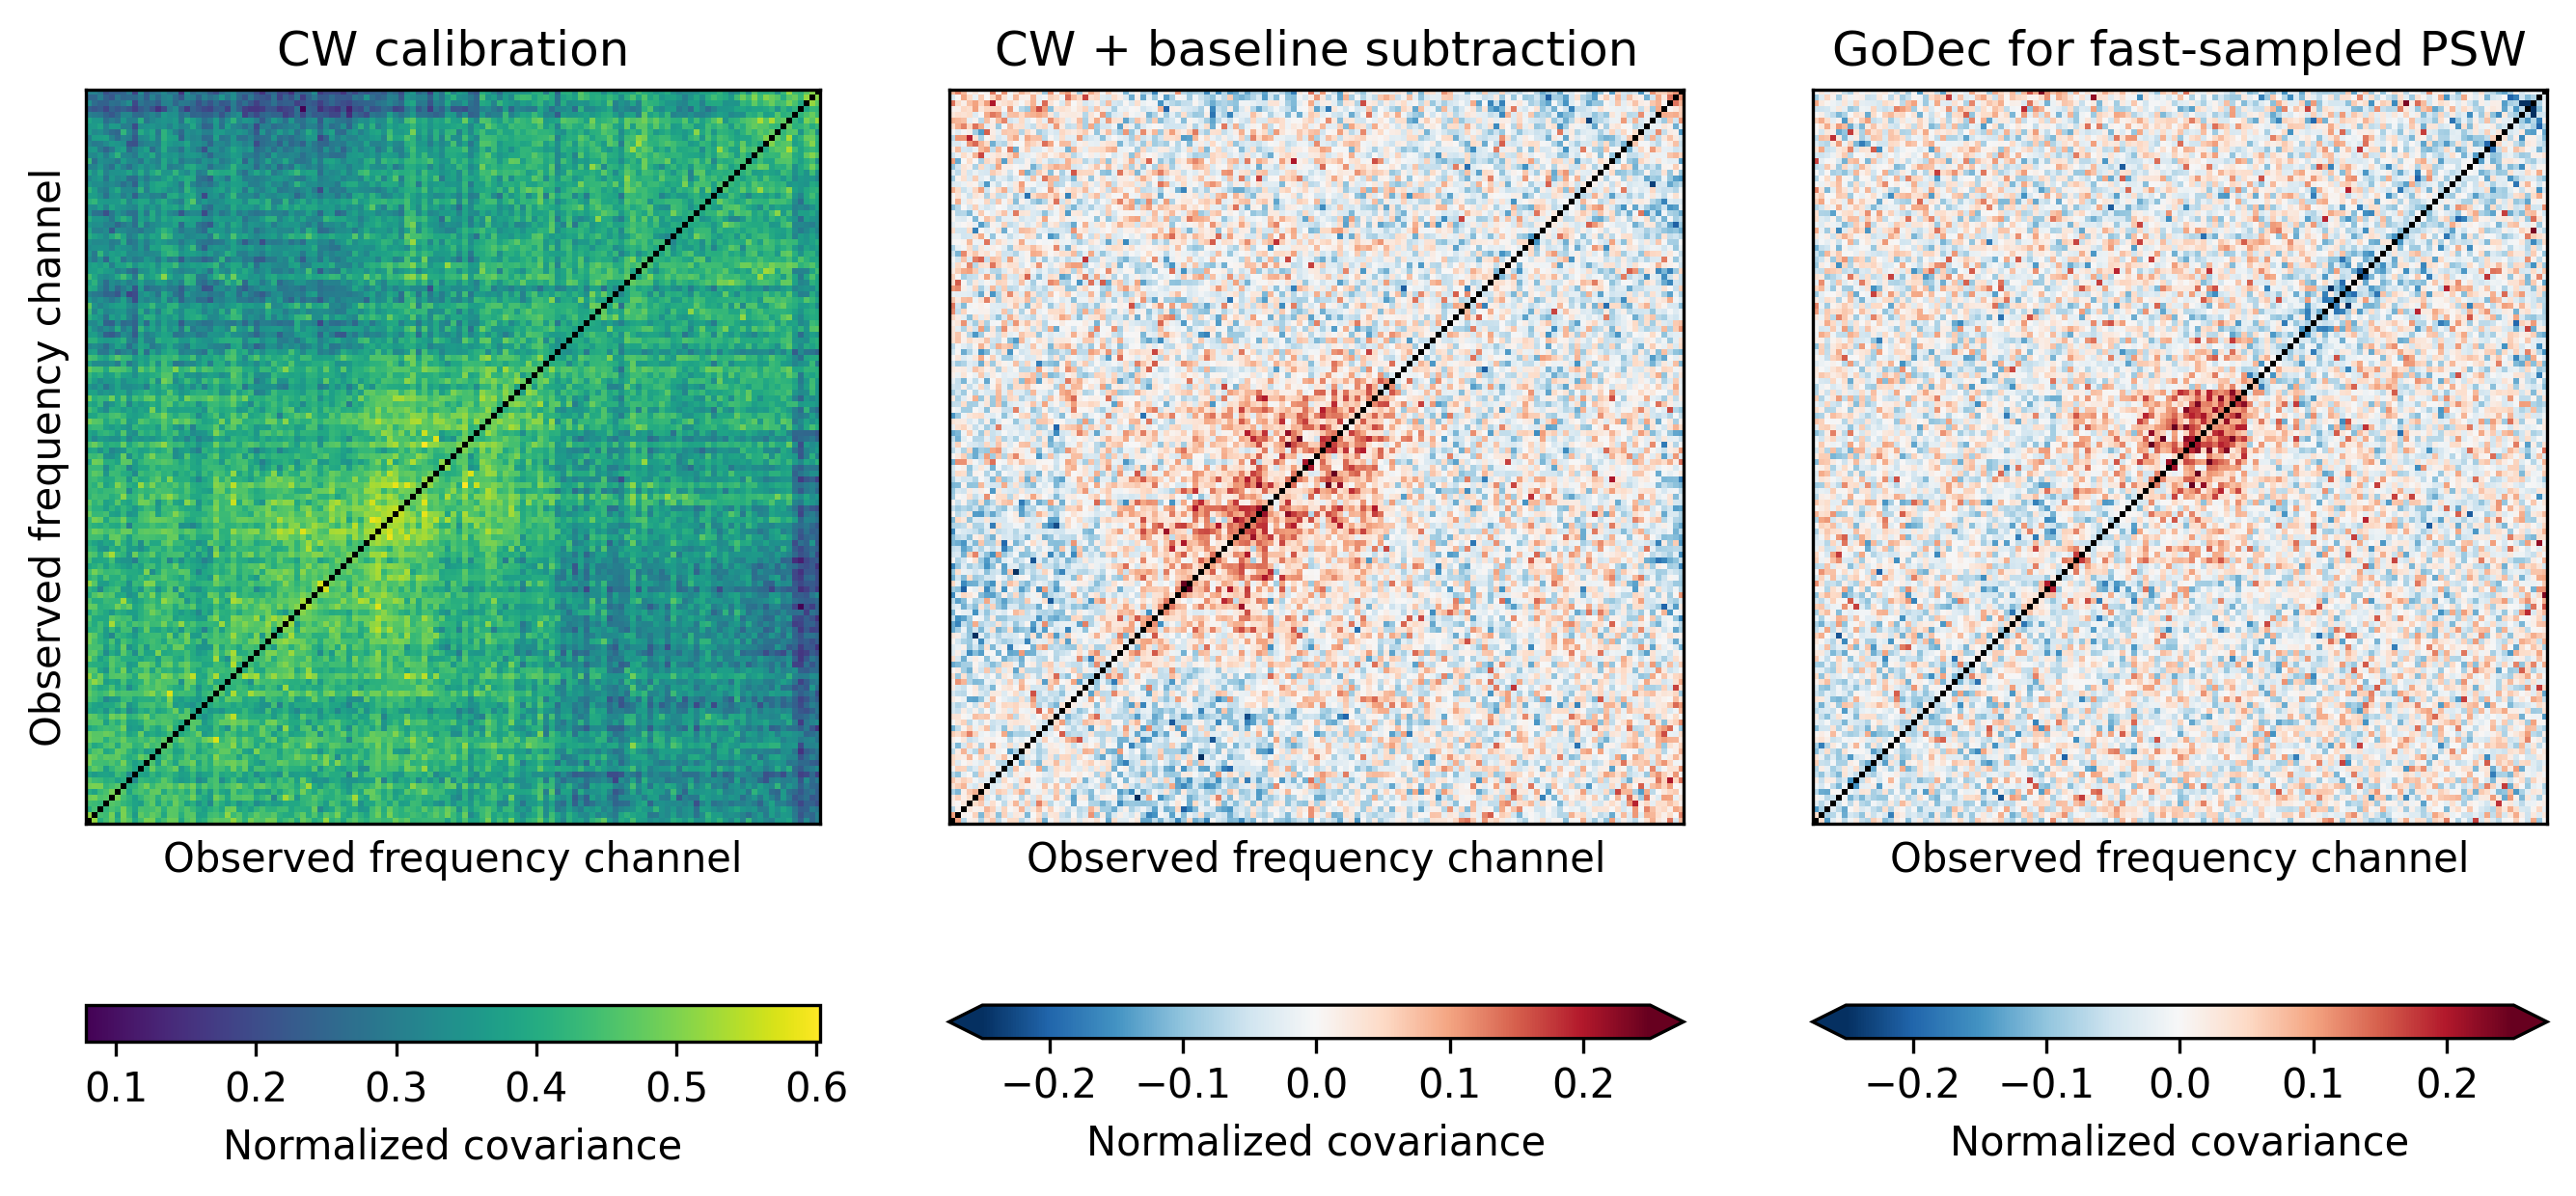

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(9, 4.5), dpi=300)

cmap = plt.cm.viridis
cmap.set_bad("black")

cmap_pm = plt.cm.RdBu_r
cmap_pm.set_bad("black")

ax = axes[0]
im = ax.imshow(cov(T_cal_org)[1:, 1:], origin="lower", cmap=cmap)
fig.colorbar(im, ax=ax, orientation="horizontal", label="Normalized covariance")
ax.set_title("CW calibration")

ax = axes[1]
im = ax.imshow(cov(T_cal)[1:, 1:], origin="lower", cmap=cmap_pm, vmin=-0.25, vmax=0.25)
fig.colorbar(im, ax=ax, orientation="horizontal", extend="both", label="Normalized covariance")
ax.set_title("CW + baseline subtraction")

ax = axes[2]
im = ax.imshow(cov(T_cal_re)[1:, 1:], origin="lower", cmap=cmap_pm, vmin=-0.25, vmax=0.25)
fig.colorbar(im, ax=ax, orientation="horizontal", extend="both", label="Normalized covariance")
ax.set_title("GoDec for fast-sampled PSW")

for i, ax in enumerate(axes.flatten()):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("Observed frequency channel")
    
    if i == 0:
        ax.set_ylabel("Observed frequency channel")
    else:
        ax.set_ylabel(" ")

fig.tight_layout()
savefig_in_notebook(fig, "covariance-PJ020941_3-CO54.pdf")

/Users/akio/Repos/Reform/reform-analysis/.venv/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/akio/Repos/Reform/reform-analysis/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/akio/Repos/Reform/reform-analysis/.venv/lib/python3.8/site-packages/xarray/core/dataarray.py:1924: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return self.transpose()


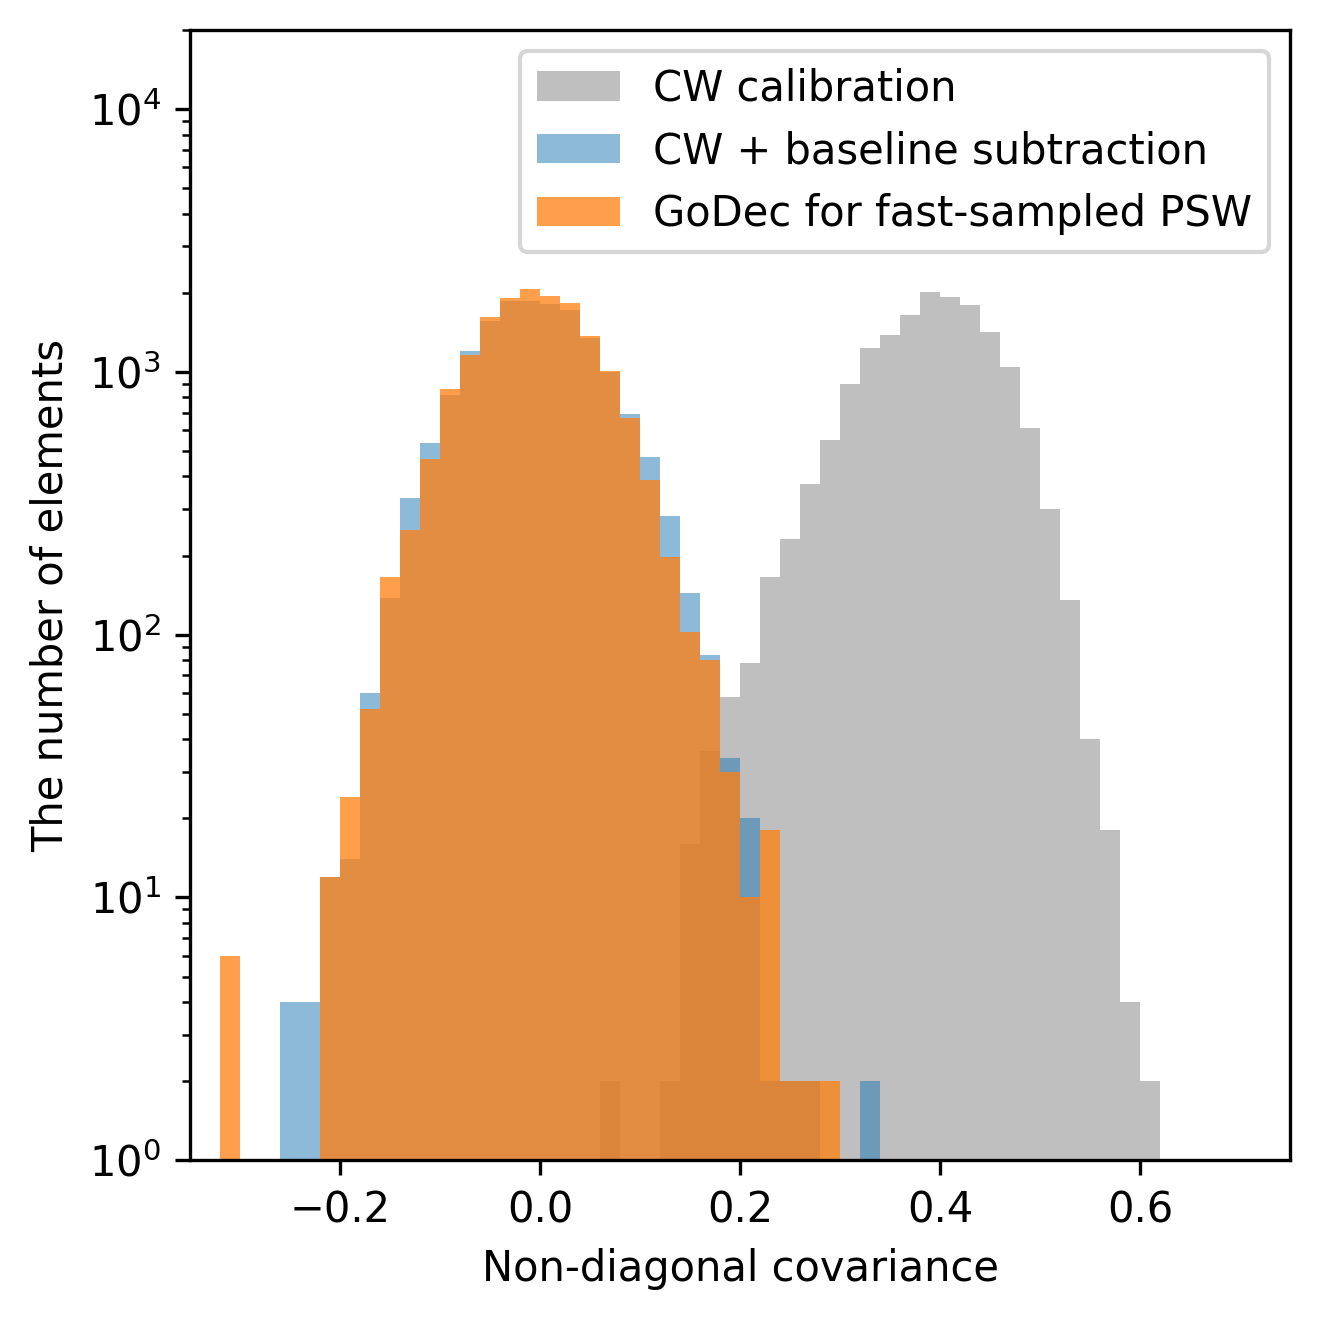

In [12]:
fig, ax = plt.subplots(figsize=(4.5, 4.5), dpi=300)

bins = np.arange(-1.00, 1.02, 0.02)

ax.hist(cov(T_cal_org).flatten(),
        bins=bins, alpha=0.5, color="gray", label="CW calibration")
ax.hist(cov(T_cal).flatten(),
        bins=bins, alpha=0.5, label="CW + baseline subtraction")
ax.hist(cov(T_cal_re).flatten(),
        bins=bins, alpha=0.75, label="GoDec for fast-sampled PSW")

ax.set_xlabel("Non-diagonal covariance")
ax.set_ylabel("The number of elements")
ax.set_xlim(-0.35, 0.75)
ax.set_ylim(1e0, 2e4)
ax.set_yscale("log")
ax.legend(loc="upper right")

fig.tight_layout()
savefig_in_notebook(fig, "covariance-histogram-PJ020941_3-CO54.pdf")

## Observed time vs noise level (standard deviation)

In [13]:
T_base = xr.concat([T_cal.loc[:, :162.9], T_cal.loc[:, 161.9:]], "ch")
T_base_re = xr.concat([T_cal_re.loc[:, :162.9], T_cal_re.loc[:, 161.9:]], "ch")

cumstd = (T_base.cumsum("t") / xr.ones_like(T_base).cumsum("t")).std("ch")
cumstd_re = (T_base_re.cumsum("t") / xr.ones_like(T_base_re).cumsum("t")).std("ch")
cumint = T_base.integtime.cumsum("t")

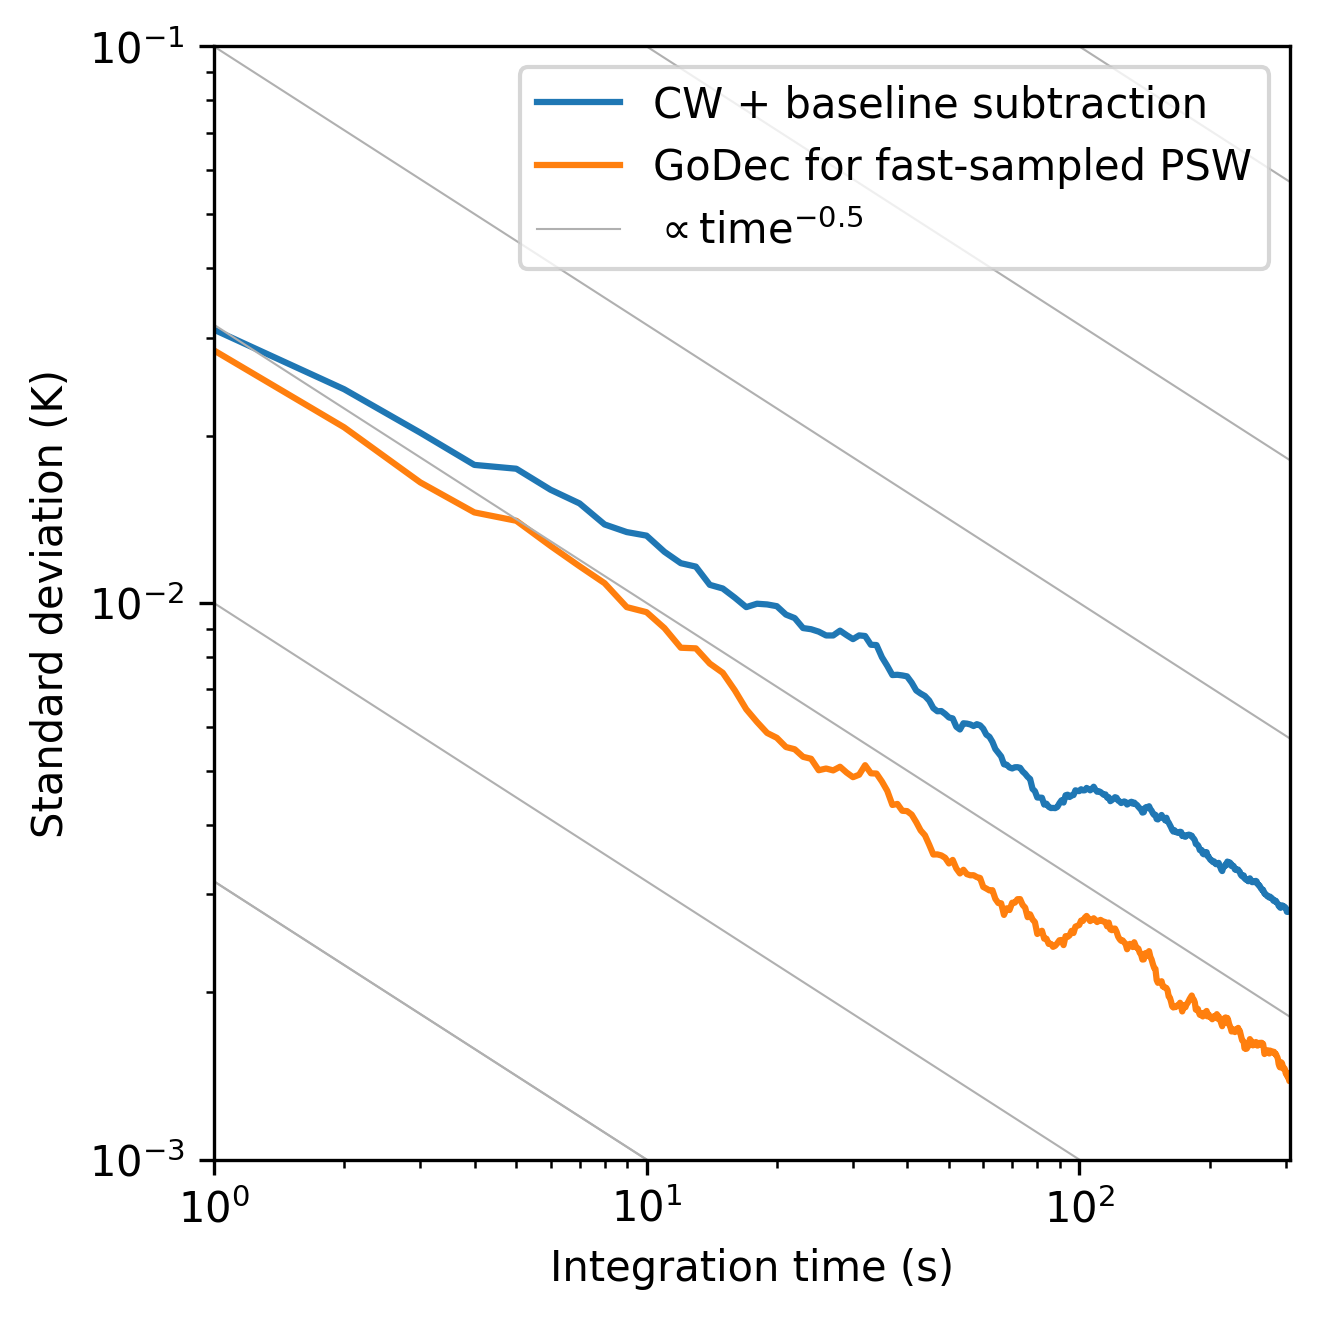

In [14]:
fig, ax = plt.subplots(figsize=(4.5, 4.5), dpi=300)

ax.plot(cumint, cumstd, label="CW + baseline subtraction")
ax.plot(cumint, cumstd_re, label="GoDec for fast-sampled PSW")

for i, dex in enumerate([-2.5, -2.0, -1.5, -1.0, -0.5, 0.0]):
    if i == 0:
        label = "$\propto \mathrm{time}^{-0.5}$"
        ax.plot(cumint, 10**dex * cumint**-0.5, lw=0.5, c="#b0b0b0", label=label)
    
    ax.plot(cumint, 10**dex * cumint**-0.5, lw=0.5, c="#b0b0b0")

ax.set_xlabel("Integration time (s)")
ax.set_ylabel("Standard deviation (K)")
ax.set_xlim(cumint.min(), cumint.max())
ax.set_ylim(1e-3, 1e-1)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="upper right")

fig.tight_layout()
savefig_in_notebook(fig, "time-vs-noise-PJ020941_3-CO54.pdf")